# Creating a custom YOLOv9 Model which is trained (fine-tuned) on PLATE DETECTION _HuggingFace Dataset_

## YOLOv9 COCO Performance

Implementation of paper - [YOLOv9: Learning What You Want to Learn Using Programmable Gradient Information](https://arxiv.org/abs/2402.13616)

<div align="center">
    <a href="./">
        <img src="https://huggingface.co/adonaivera/yolov9/resolve/main/performance.png" width="79%"/>
    </a>
</div>


### Performance of each model according to params

MS COCO

| Model | Test Size | AP<sup>val</sup> | AP<sub>50</sub><sup>val</sup> | AP<sub>75</sub><sup>val</sup> | Param. | FLOPs |
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| [**YOLOv9-S**]() | 640 | **46.8%** | **63.4%** | **50.7%** | **7.2M** | **26.7G** |
| [**YOLOv9-M**]() | 640 | **51.4%** | **68.1%** | **56.1%** | **20.1M** | **76.8G** |
| [**YOLOv9-C**](https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt) | 640 | **53.0%** | **70.2%** | **57.8%** | **25.5M** | **102.8G** |
| [**YOLOv9-E**](https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt) | 640 | **55.6%** | **72.8%** | **60.6%** | **58.1M** | **192.5G** |


# Install Packages

In [1]:
!git clone --recursive https://github.com/WongKinYiu/yolov9.git
%cd yolov9/

Cloning into 'yolov9'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 211 (delta 56), reused 27 (delta 27), pack-reused 141
Receiving objects: 100% (211/211), 642.68 KiB | 5.10 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/kaggle/working/yolov9


# Install YOLOv9 Dependencies

In [2]:
!pip install -r requirements.txt -q
!pip install supervision datasets pyyaml -q

# Import necessary Libraries

In [3]:
from PIL import Image
import warnings
import torch
import cv2
import glob
import os
import random

import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import matplotlib.patches as patches

warnings.simplefilter('ignore')

In [4]:
HOME = os.getcwd()
HOME # Rightnow the yolov9 is our current directory.

'/kaggle/working/yolov9'

In [5]:
from datasets import load_dataset, DatasetDict

# Get pre-trained weights from Official YOLOv9 Repository

In [6]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

# Install and Import Custom Dataset from HuggingFace

In [7]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset("keremberke/license-plate-object-detection", name='full')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset licenseplateobjectdetection downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___licenseplateobjectdetection/full/1.0.0/e7740c5ed939eb2184b6f17aee84b3a304e2f46f093835a839bcf19f0ca38ce4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Looking at random sample from the dataset's test split

In [8]:
def show_random_plate(dataset: DatasetDict, random_index: int = 64, from_where: str = 'test') -> None:
    _, ax = plt.subplots(1)

    random_range = len(dataset[from_where])

    assert random_index <= random_range, f'Dataset includes {random_range} samples. You should assign less or equal number to random_index.'

    random_sample = dataset[from_where][random_index]
    img = random_sample['image']

    ax.imshow(img)

    plates = random_sample['objects']['bbox']

    for plate_index in range(len(plates)):

        x, y, height, width = plates[plate_index]

        rect = patches.Rectangle((x, y), height, width, fill=False, linewidth=2, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    ax.axis('off')

    plt.show()

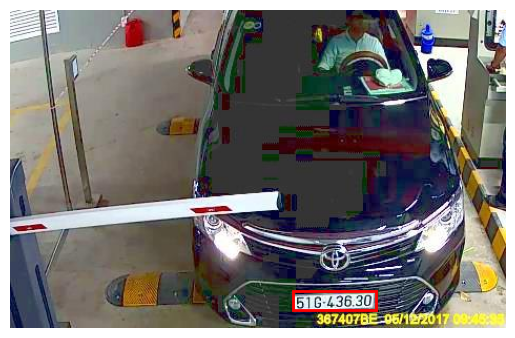

In [9]:
show_random_plate(dataset=dataset, from_where='test')

# Transform the dataset into desired YOLOv9 train format.

In [10]:
def datasets_transform(dataset, base_dir: str) -> None:

    splits = ['train', 'validation', 'test']

    for split in splits:

        if not os.path.exists(f'{base_dir}/data/{split}'):

            # if the demo_folder directory is not present
            # then create it.
            os.makedirs(f'{base_dir}/data/{split}/images/')
            os.makedirs(f'{base_dir}/data/{split}/labels/')

        for row in dataset[split]:

            row['image'].save(fp=f"{base_dir}/data/{split}/images/{row['image_id']}.jpg")

            lines = []

            objects = {
                'id': row['objects']['id'],
                'area': row['objects']['area'],
                'bbox': row['objects']['bbox'],
                'category': row['objects']['category']
            }

            image_width = row['width']
            image_height = row['height']

            for i in range(len(objects['id'])):
                category = objects['category'][i]
                bbox = objects['bbox'][i]

                # Calculate normalized coordinates for the bounding box
                x_center = (bbox[0] + bbox[2] / 2) / image_width
                y_center = (bbox[1] + bbox[3] / 2) / image_height
                width_normalized = bbox[2] / image_width
                height_normalized = bbox[3] / image_height

                # Create a inline YOLO format
                line = f"{category} {x_center} {y_center} {width_normalized} {height_normalized}"
                lines.append(line)


            file_name = f"{base_dir}/data/{split}/labels/{row['image_id']}.txt"
            with open(file_name, 'a') as f:
                for line in lines:
                    f.write(line + '\n')

In [11]:
datasets_transform(dataset=dataset, base_dir=HOME)

print('\033[92mSUCCESSFULLY TRANSFORMED INTO DESIRED YOLOv9 FORMAT!\033[0m')

SUCCESSFULLY TRANSFORMED INTO DESIRED YOLOv9 FORMAT!


# Create a YAML file for training

In [12]:
def create_yaml(base_dir: str):
    import yaml

    data_yaml = {
        'train': 'data/train/images',
        'val': 'data/validation/images',
        'test': 'data/test/images',
        'nc': 1, # number of the classes, in our cases is just 1 because we only want to detect license plate,
        'names': {
            0: 'license_plate'
        },
    }

    with open(f'{base_dir}/custom_data.yaml', 'w') as file:
        yaml.dump(data_yaml, file)

create_yaml(base_dir=HOME)

# Available Models

In [13]:
MODELS: dict = {
    'GELAN-C': {
        'yaml': 'models/detect/gelan-c.yaml',
        'weights': f'{HOME}/weights/gelan-c.pt'
    },
    'GELAN-E': {
        'yaml': 'models/detect/gelan-e.yaml',
        'weights': f'{HOME}/weights/gelan-e.pt'
    },
    'YOLOv9-C': {
        'yaml': 'models/detect/yolov9-c.yaml',
        'weights': f'{HOME}/weights/yolov9-c.pt'
    },
    'YOLOv9-E': {
        'yaml': 'models/detect/yolov9-e.yaml',
        'weights': f'{HOME}/weights/yolov9-e.pt'
    },
}

# Weight & Biases initializing

In [14]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb-api")
wandb.login(key=wandb_api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# PARAMS for TRAINING

In [15]:
CUSTOM_DATA_YAML_PATH: str = os.path.join(HOME, 'custom_data.yaml') # CUSTOM DATA PATH
EPOCHS: int = 20 # Number of the EPOCHS
BATCH_SIZE: int = 16 # Number of the Image in the batch
SELECTED_MODEL: dict = MODELS.get('GELAN-C') # WE WILL TRAIN GELAN-C
YAML_PATH: str = SELECTED_MODEL.get('yaml') # MODEL CONFIG YAML PATH
WEIGHTS_PATH: str = SELECTED_MODEL.get('weights') # MODEL PRE-TRAINED WEIGHTS PATH
DEVICE: str | int = 0 if torch.cuda.is_available() else 'cpu' # SELECT DEVICE IF GPU IS AVAILABLE SELECT GPU ELSE CPU

# Start TRAINING

In [16]:
!python train.py \
--batch {BATCH_SIZE} --epochs {EPOCHS} --device {DEVICE} --img 640 --min-items 0 --close-mosaic 15 \
--data {CUSTOM_DATA_YAML_PATH} \
--weights {WEIGHTS_PATH} \
--cfg {YAML_PATH} \
--hyp hyp.scratch-high.yaml

2024-02-28 00:49:22.751898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 00:49:22.752018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 00:49:22.927933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: berkayozcelik77. Use `wandb login --relogin` to force relogin
train: weights=/kaggle/working/yolov9/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/kaggle/working/yolov9/custom_data.yaml, hyp=hyp.scratch-high.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False,

# Training History

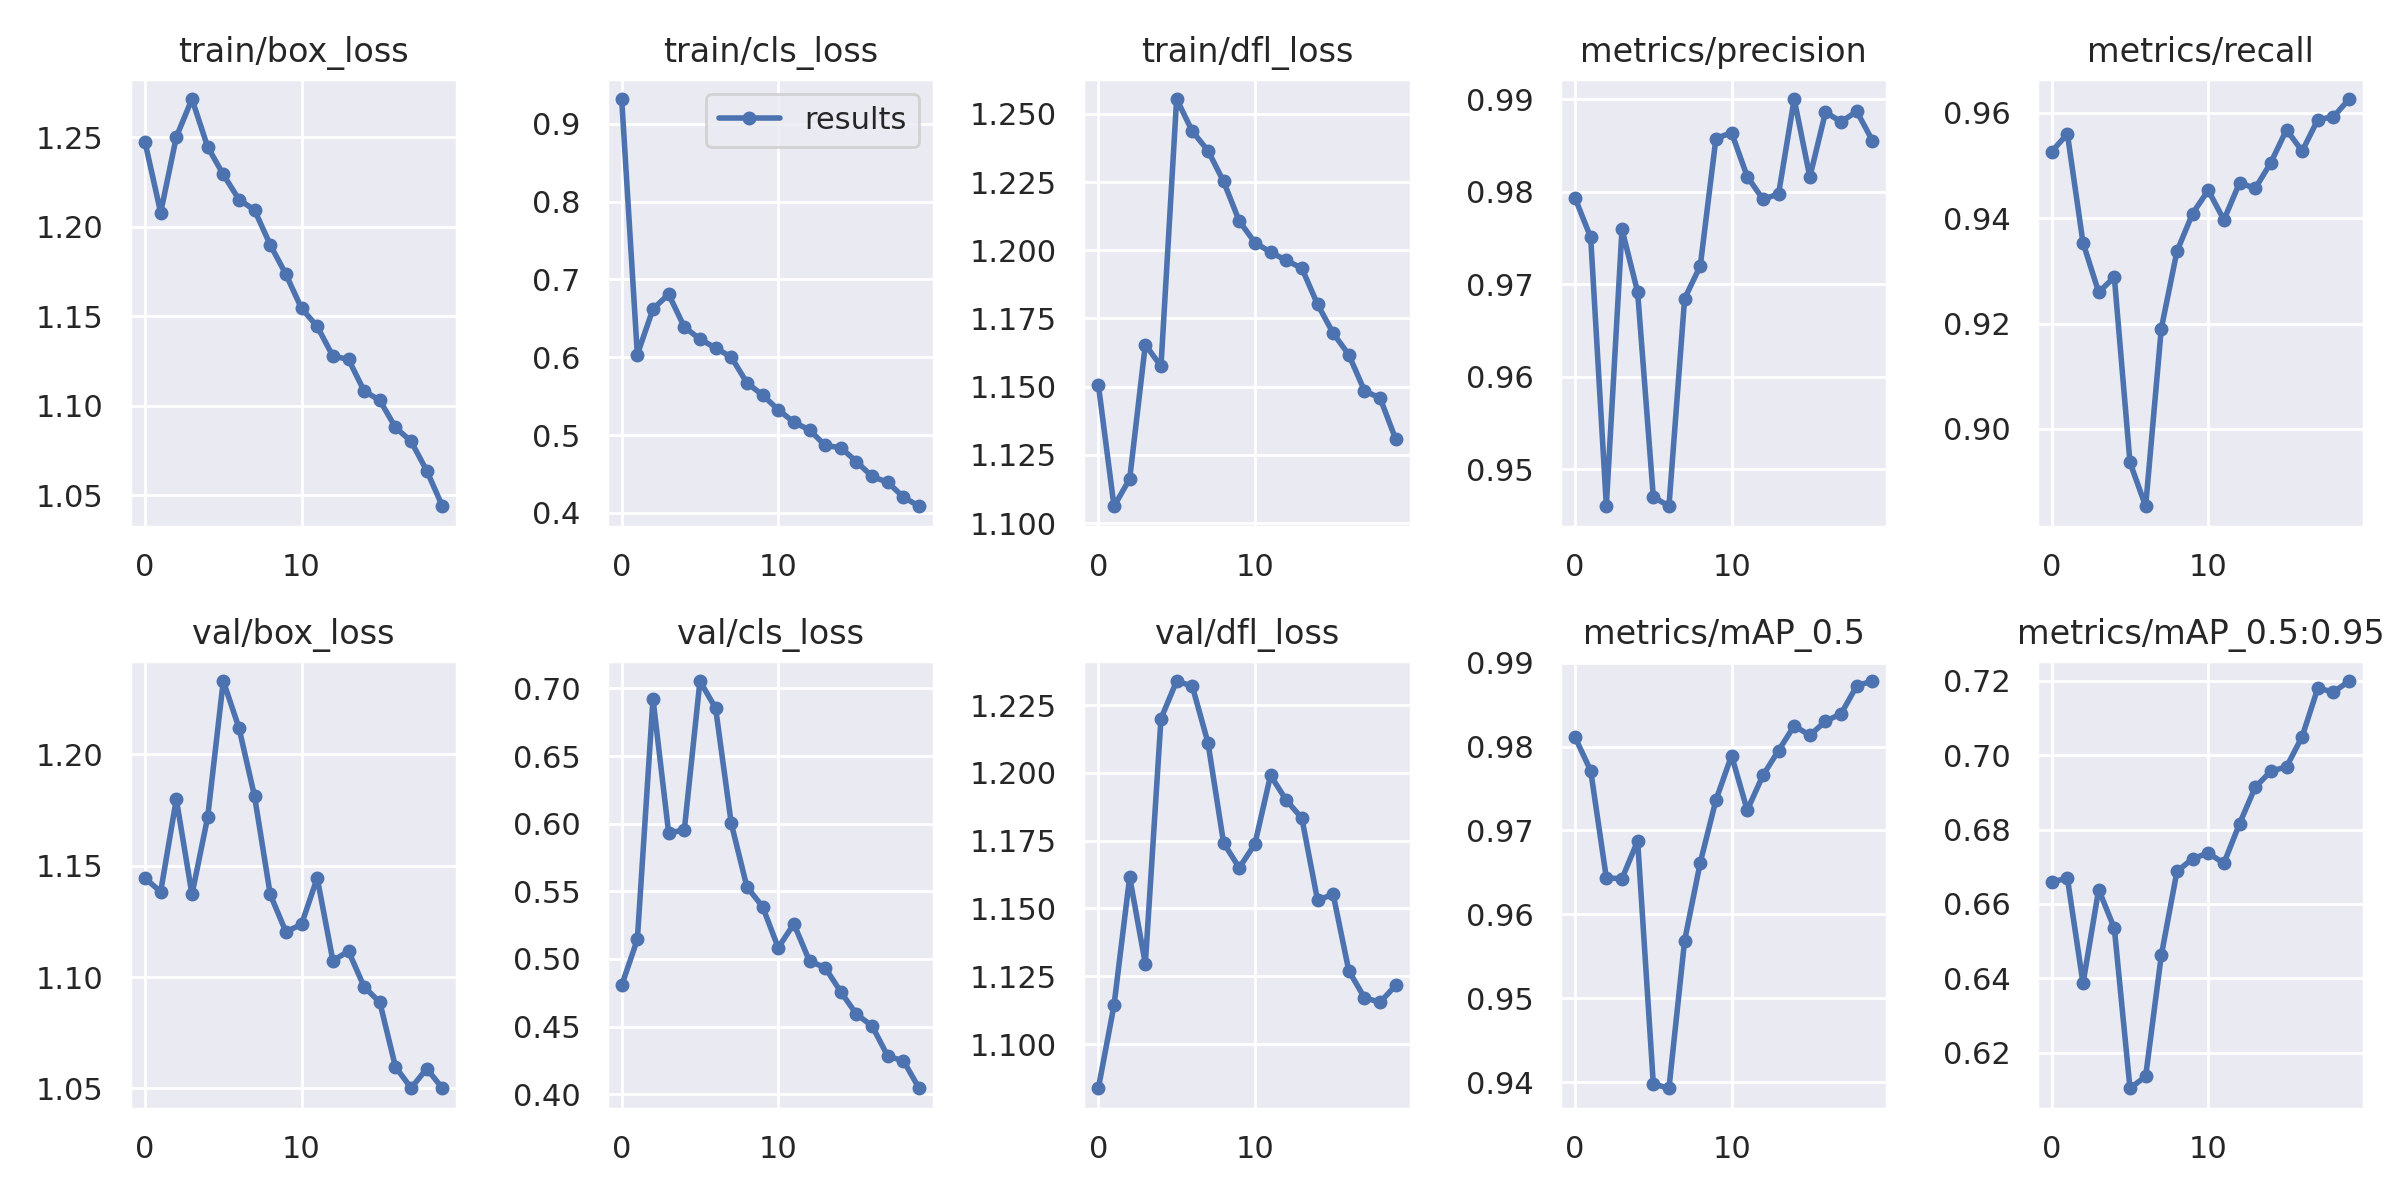

In [17]:
HISTORY_PATH = os.path.join(HOME, 'runs/train/exp/results.png')
training_history = Image.open(HISTORY_PATH)
training_history

# Prediction on test data using fine-tuned weights

In [18]:
FINETUNED_WEIGHTS_PATH = os.path.join(HOME, 'runs/train/exp/weights/best.pt')
TEST_DIR_PATH = os.path.join(HOME, 'data/test/images')

In [19]:
!python detect.py \
--img 1280 --conf 0.5 --device 0 \
--weights {FINETUNED_WEIGHTS_PATH} \
--source {TEST_DIR_PATH}

detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/best.pt'], source=/kaggle/working/yolov9/data/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v0.1-23-ga31de4e Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25227859 parameters, 0 gradients, 101.8 GFLOPs
image 1/882 /kaggle/working/yolov9/data/test/images/0.jpg: 832x1280 1 license_plate, 114.3ms
image 2/882 /kaggle/working/yolov9/data/test/images/1.jpg: 736x1280 1 license_plate, 120.5ms
image 3/882 /kaggle/working/yolov9/data/test/images/10.jpg: 832x1280 1 license_plate, 72.6ms
image 4/882 /kaggle/worki

# Visualize test predictions

In [20]:
%matplotlib inline

In [23]:
def show_random_results():
    img_path = glob.glob(f'{HOME}/runs/detect/exp/*.jpg')
    random_images = random.sample(img_path, 9) # get 9 img_path from path of images
    nrows, ncols = (3, 3)
    
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    
    for i, ax in enumerate(axes.flat):
        img = Image.open(random_images[i])
        ax.axis('off')
        ax.imshow(img)
        
    plt.show()

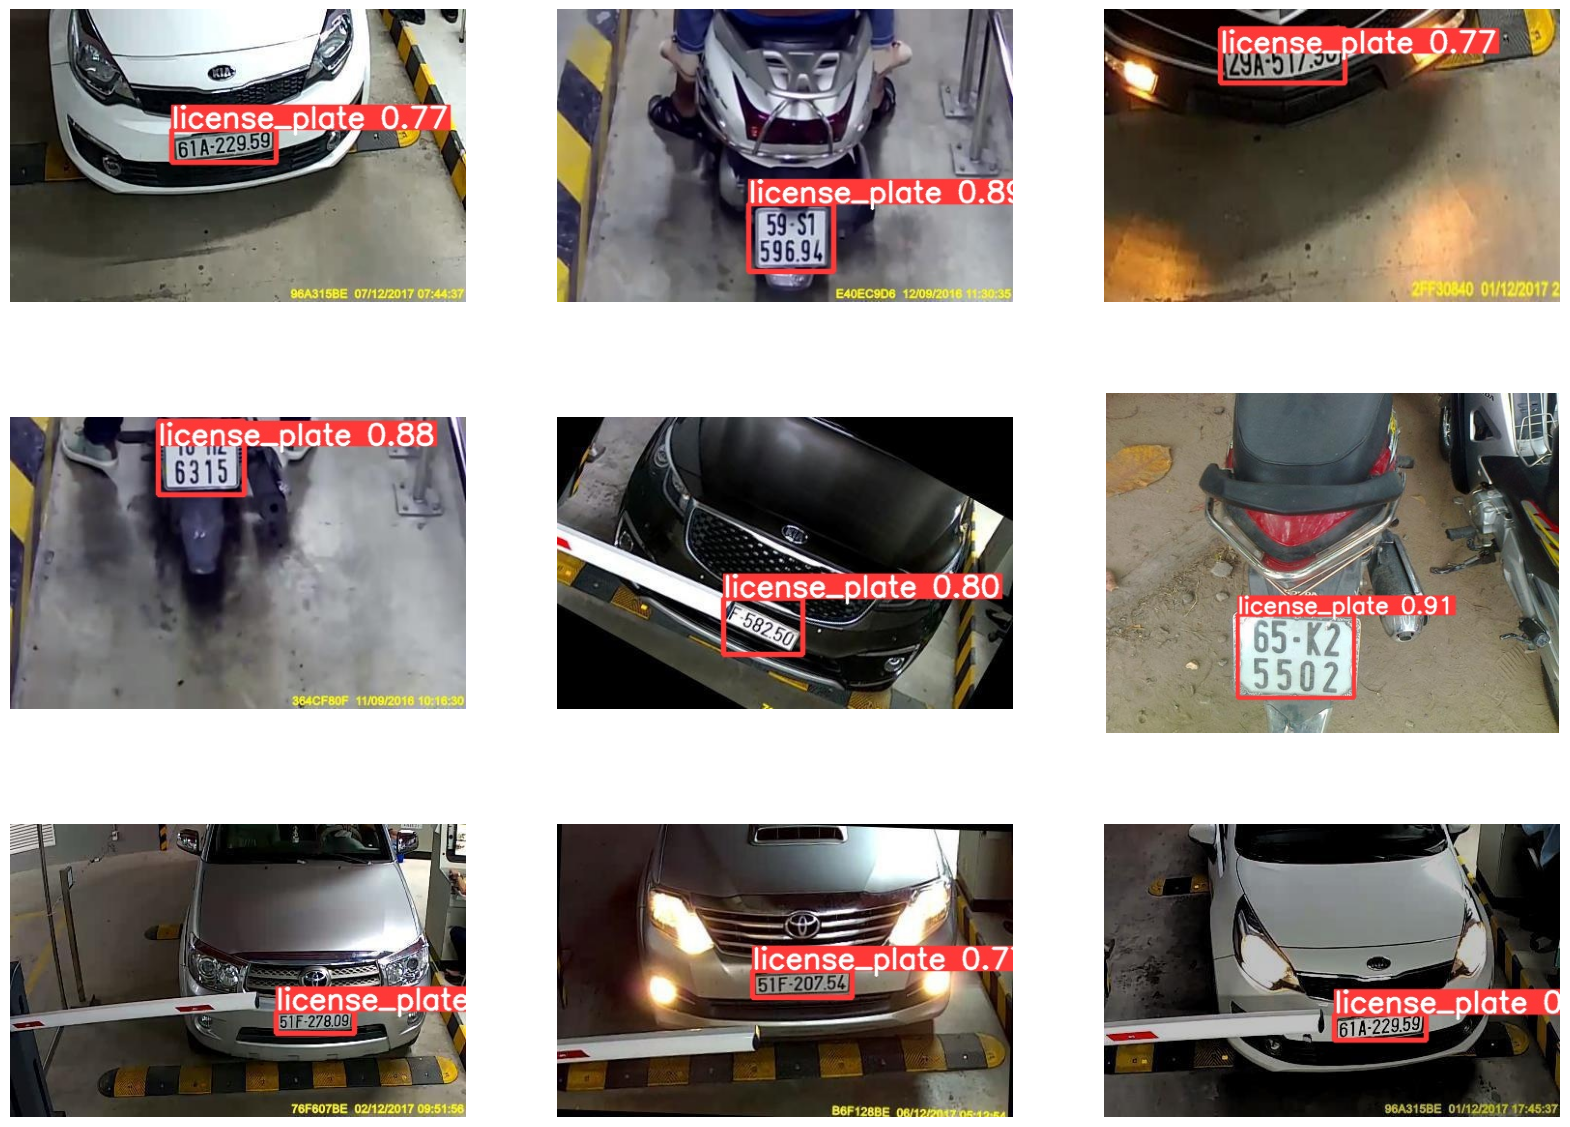

In [25]:
show_random_results()

# Custom Inference Function

## Import Inference Utils

In [35]:
from models.common import DetectMultiBackend
from utils.general import check_img_size, non_max_suppression, scale_boxes
from utils.torch_utils import select_device, smart_inference_mode
from utils.augmentations import letterbox

This function is originally written by Merve Noyan.

In [36]:
@smart_inference_mode()
def predict(
    image_path: str,
    weights: str,
    data: str,
    imgsz: tuple,
    conf_thres: float,
    iou_thres: float,
    device: str,
):
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, fp16=False, data=data)
    stride, names, pt = model.stride, model.names, model.pt

    # Load image
    image = Image.open(image_path)
    img0 = np.array(image)
    assert img0 is not None, f'Image Not Found {image_path}'
    img = letterbox(img0, imgsz, stride=stride, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Init bounding box annotator and label annotator
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_RIGHT, text_scale=0.4)

    # Inference
    pred = model(img, augment=False, visualize=False)

    # Apply NMS
    pred_t = non_max_suppression(pred[0], conf_thres, iou_thres, classes=None, max_det=1000)

    # Process detections
    for i, det in enumerate(pred_t):
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in reversed(det):
                # Transform detections to supervisions detections
                detections = sv.Detections(
                    xyxy=torch.stack(xyxy).cpu().numpy().reshape(1, -1),
                    class_id=np.array([int(cls)]),
                    confidence=np.array([float(conf)])
                )

                # Labels
                labels = [
                    f"{names[int(class_id)]} {confidence:0.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]

                img0 = bounding_box_annotator.annotate(img0, detections)
                img0 = label_annotator.annotate(img0, detections, labels)

        return img0

In [28]:
image_path = f'{HOME}/data/test/images/833.jpg'
image_path

'/kaggle/working/yolov9/data/test/images/833.jpg'

In [29]:
%matplotlib inline

YOLOv5 🚀 v0.1-23-ga31de4e Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25227859 parameters, 0 gradients, 101.8 GFLOPs


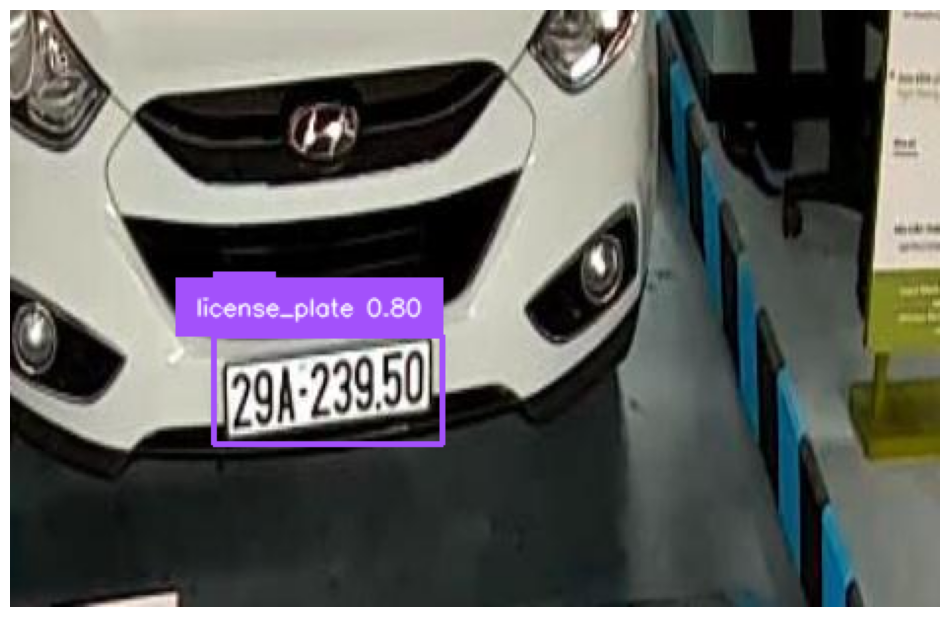

In [37]:
img = predict(
    image_path=image_path,
    weights=FINETUNED_WEIGHTS_PATH,
    data=CUSTOM_DATA_YAML_PATH,
    imgsz=640,
    conf_thres=0.5,
    iou_thres=0.2,
    device=DEVICE,
)

sv.plot_image(img)

# Access Pretrained Plate Detection Weights 

## [Plate Detection Pretrained Weights Click here!](https://www.kaggle.com/datasets/noepinefrin/yolov9-fine-tuned-plate-detection-model-weights)